# Electricity Consumption Forecasting

## Author: David Xiong

## 1. Excutive Summary

### Decisions to be impacted
This project aims to forecast electricity consumption to enhance power supply predictions, helping energy providers allocate resources efficiently, manage demand, and maintain grid stability. These insights optimize energy distribution, lower operational costs, and reduce environmental impact by minimizing waste.

### Business Value
Accurate electricity consumption forecasting benefits both businesses and society. For businesses, it reduces energy waste, improves efficiency, and cuts costs. For society, it supports grid stability, promotes sustainable energy policies, and reduces environmental impact. Ultimately, it ensures reliable electricity distribution and effective resource management.

### Data Assets
The dataset for this project is the UCl individual Household Electric Power Consumption dataset, which contains detailed measurements of a single household's electricity usage in Sceaux, a French town that is 7 km away from Paris. The dataset consists of two millions records collected at one-minute intervals between December 2006 and November 2010. lt includes variables such as time, global active power, global reactive power, voltage, and sub-metering values that are important for developing a time series forecasting model.

## 2. Data Preprocessing

### Data Description
The dataset comprises 2,075,259 measurements of household electricity consumption in one-minute intervals over four years. Features include: **‘Date’** (dd/mm/yyyy), **‘Time’** (hh:mm:ss), **‘Global_active_power’** (household global minute-averaged active power (in kilowatts)), **‘Global_reactive_power’** (household global minute-averaged reactive power (in kilowatts)), **‘Voltage’** (minute-averaged voltage (in volts)), **‘Global_intensity’** (household global minute-averaged current intensity (in amperes)), **‘Sub_metering_1’** (corresponds to kitchen appliances like the dishwasher, oven, and microwave (in watt-hours of active energy)), **‘Sub_metering_2’** (corresponds to laundry appliances, including the washing machine, refrigerator, and tumble dryer (in watt-hours of active energy)), **‘Sub_metering_3’** (corresponds to an electric water heater and air conditioner (in watt-hours of active energy)), and the generated feature **‘active_energy_consumed’** (represents the active energy consumed every minute (in watt hour)) by the formula below:

**active_energy_consumed** = (Global active power × 1000) / 60 - Sub metering values

In [1]:
# import packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from scipy import stats
import statsmodels.api as sm
%matplotlib inline

matplotlib.use('TkAgg')

### Data Preprocessing Steps
**Handling Missing Values**

Missing values were identified in the dataset, represented by "?". These missing entries were filled using forward fill (ffill), in which missing values are filled by propagating the most recent non-missing value forward, to ensure time series continuity

In [2]:
# import data
data=pd.read_table('household_power_consumption.txt',sep=';',na_values='?')
data = data.fillna(method='ffill') #
# global_active_power*1000/60 - sub_metering_1 - sub_metering_2 - sub_metering_3
data['active_energy_consumed']=data['Global_active_power'].astype(float)*1000/60-data['Sub_metering_1']-data['Sub_metering_2']-data['Sub_metering_3']

**Datetime Processing**

The dataset originally included separate columns for Date and Time. To create a continuous time series representation: The Date and Time columns were combined to create a datetime object using the pd.to_datetime() function. Then there are three new columns generated: Year, Month, and Day. For the ‘day’ column, 0-6 represents weekdays from Monday to Sunday.

**Creating Daily Aggregated Data**

Created and selected the relevant columns, including Date, Year, Month, Day, and the derived column for active energy consumed (active_energy_consumed). Grouped the dataset by Date to calculate daily averages for each feature, converted the Date column back into a datetime format and sorted the data chronologically.

In [3]:
# create the daily data
dttime_temp=pd.to_datetime(data['Date'] + ' ' + data['Time'])
data.insert(2, 'Year',dttime_temp.dt.year) #year
data.insert(3, 'Month',dttime_temp.dt.month) #month
data.insert(4, 'Day',dttime_temp.dt.weekday) #weekday_name
data_clean=data.iloc[:,[0,2,3,4,12]]
data_clean=data_clean.groupby('Date',as_index=False).mean()
data_clean['Date']=pd.to_datetime(data_clean['Date'],format='%d/%m/%Y')
data_clean=data_clean.sort_values(by='Date')

In [4]:
data_clean.head(30)

,Date,Year,Month,Day,active_energy_consumed
341,2006-12-16,2006.0,12.0,5.0,37.073064
389,2006-12-17,2006.0,12.0,6.0,25.657407
437,2006-12-18,2006.0,12.0,0.0,13.214190
485,2006-12-19,2006.0,12.0,1.0,9.119375
580,2006-12-20,2006.0,12.0,2.0,14.156111
628,2006-12-21,2006.0,12.0,3.0,9.589954
676,2006-12-22,2006.0,12.0,4.0,16.937708
724,2006-12-23,2006.0,12.0,5.0,42.872523
772,2006-12-24,2006.0,12.0,6.0,20.016806
820,2006-12-25,2006.0,12.0,0.0,21.765046


In [5]:
# EDA
# summary description
data_clean['active_energy_consumed'].describe()

count    1442.000000
mean        9.301362
std         4.310367
min         1.433333
25%         6.471319
50%         8.736551
75%        11.478050
max        42.872523
Name: active_energy_consumed, dtype: float64

Per the variable distribution, we can see the mean daily active_energy_consumed is about 9.3 and the standard deviation is 4.31, indicating a moderate variability. Besides, 25th percentile (6.47), median (8.74), and 75th percentile (11.48) show that the data is skewed, with the upper quartile containing higher consumption values.

### Visualizations and Summary

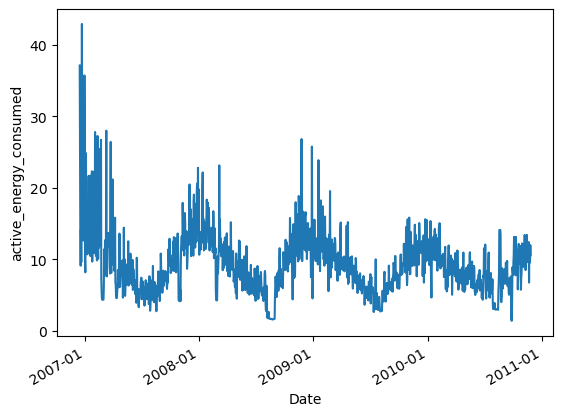

In [6]:
# first visualization
sns.lineplot(x=data_clean['Date'],y=data_clean['active_energy_consumed'])

# Improve x-axis formatting
plt.gca().xaxis.set_major_locator(mdates.YearLocator())  # Set major ticks at yearly intervals
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  # Format tick labels as Year-Month

# Rotate labels for better readability
plt.gcf().autofmt_xdate()

%matplotlib inline
plt.show()

This graph displays the daily active energy consumption in watt-hours over four years. It shows a high initial consumption in early 2007, followed by a gradual decline and periodic fluctuations. Seasonal patterns emerge with higher usage in winter and lower usage in summer, reflecting temperature-dependent consumption.

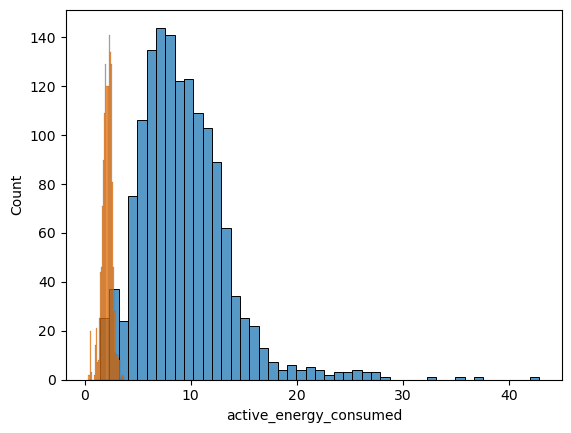

In [7]:
# histogram
sns.histplot(data_clean['active_energy_consumed'])
sns.histplot(np.log(data_clean['active_energy_consumed']))
# thus log-transformation is performed
data_clean['active_energy_consumed_log']=np.log(data_clean['active_energy_consumed'])

%matplotlib inline
plt.show()

This histogram shows the distribution of daily active energy consumption, with most values concentrated in the interval between 0 and 10 watt-hours. The right-skewed shape indicates a few high-consumption outliers, suggesting that extreme energy usage is rare. The log transformation was applied to stabilize variance and normalize the data.

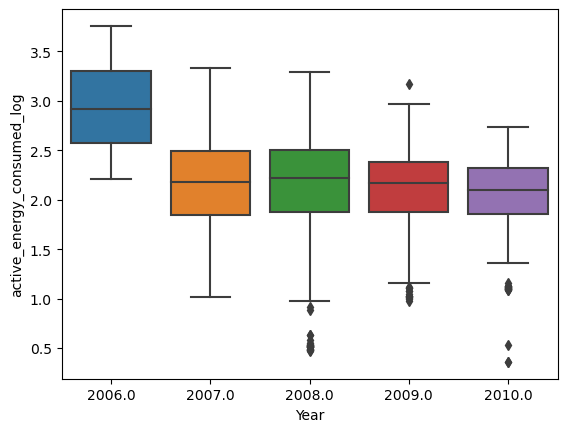

In [8]:
# relationship between active_energy_consumed and years\month\day
sns.boxplot(x=data_clean['Year'],y=data_clean['active_energy_consumed_log'])
plt.show()

This box plot shows the log-transformed ‘active_energy_consumption’ across years from 2006 to 2010. Median consumption remains relatively stable except for 2006, but outliers appear consistently below each year's range, particularly in 2008 and 2009. Consumption variability decreases slightly over time, with 2006 showing the highest spread.

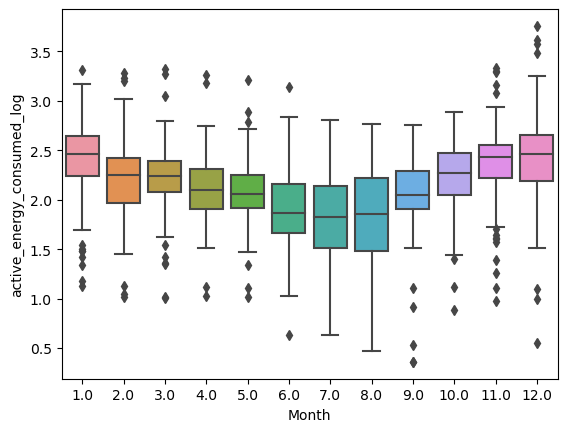

In [9]:
sns.boxplot(x=data_clean['Month'],y=data_clean['active_energy_consumed_log'])
plt.show()

This box plot displays monthly trends in log-transformed active energy consumption, revealing clear seasonal variations. Winter months, particularly January, November, and December, exhibit higher median consumption and larger interquartile ranges, reflecting increased energy use and greater variability during colder months. This pattern is likely due to higher heating demands. In contrast, summer months, especially July and August, show lower median consumption and fewer outliers, suggesting reduced energy needs, possibly due to less reliance on heating systems. Outliers are present across most months, but winter months have more extreme values, highlighting peak energy demands during colder periods of the year.

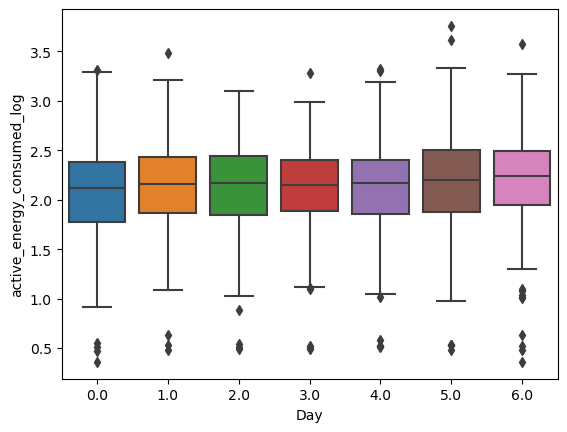

In [10]:
sns.boxplot(x=data_clean['Day'],y=data_clean['active_energy_consumed_log'])
plt.show()

This box plot shows log-transformed active energy consumption by day of the week, from Monday (0) to Sunday (6). Median consumption is relatively consistent across all days, with slightly higher usage mid-week. Outliers are present every day, though weekends have more, suggesting occasional peak demands outside the regular weekday pattern.

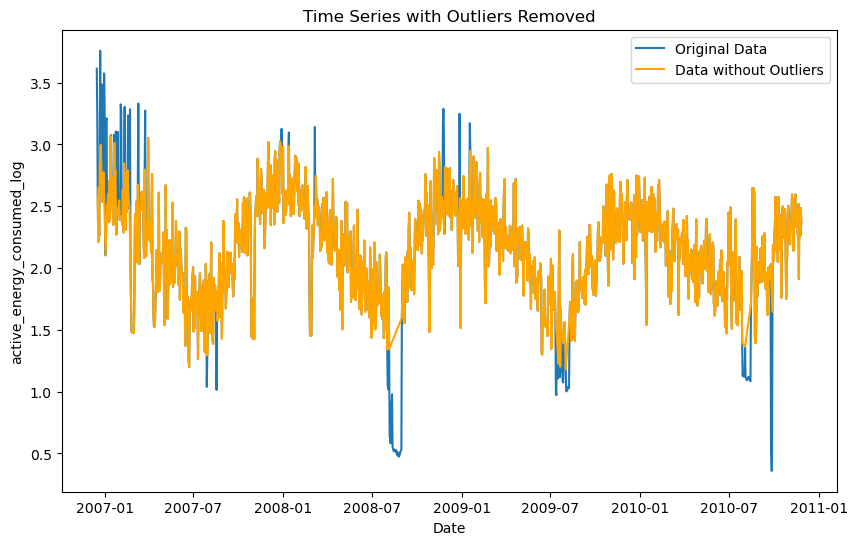

In [11]:
data_clean['Z_score'] = np.abs(stats.zscore(data_clean['active_energy_consumed_log']))

# Filter out data points where the Z-score is greater than 2
threshold = 2
data_clean_no_outliers = data_clean[data_clean['Z_score'] < threshold]

# Plot the cleaned data
plt.figure(figsize=(10, 6))
plt.plot(data_clean['Date'], data_clean['active_energy_consumed_log'], label='Original Data')
plt.plot(data_clean_no_outliers['Date'], data_clean_no_outliers['active_energy_consumed_log'], label='Data without Outliers', color='orange')
plt.title('Time Series with Outliers Removed')
plt.xlabel('Date')
plt.ylabel('active_energy_consumed_log')
plt.legend()
plt.show()

I used the **Z-score** approach to detect outliers by calculating the absolute Z-score of each data point in active_energy_consumed_log. Data points with a Z-score greater than the threshold of 2 are identified as outliers and removed. The graph shows the original data in blue and the cleaned data in orange, which effectively reduces the impact of extreme values, making trends more visible.

## 3. Model Updates

A **linear regression model** was initially implemented to predict log-transformed daily electricity consumption. The residual analysis showed autocorrelation, suggesting that time series models like SARlMA are more appropriate.

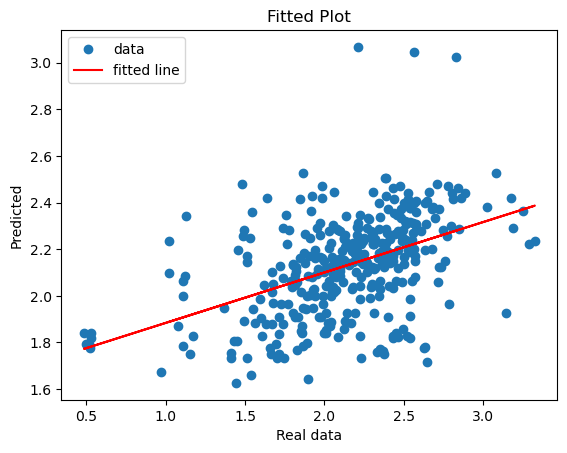

0.20980864230535695

In [20]:
# Raw model (linear Regression)
x = data_clean[['Year','Month','Day']]
x = pd.get_dummies(x.astype('str'),drop_first=True)
y = data_clean['active_energy_consumed_log']
x_train,x_test,y_train,y_test=train_test_split(x, y, train_size=0.75, test_size = 0.25, random_state=1)

lm = LinearRegression()
model = lm.fit(x_train, y_train)
predictions=lm.predict(x_test)
slope, intercept, r_value, p_value, std_err = stats.linregress(y_test, predictions)

plt.plot(y_test, predictions, 'o', label='data')
plt.plot(y_test, intercept + slope*y_test, 'r', label='fitted line')
plt.legend()
plt.xlabel('Real data')
plt.title('Fitted Plot')
plt.ylabel('Predicted')
plt.show()
# r2
r_value**2 # R2=0.210

**Residual Plot:** A plot of residuals was created to evaluate the linear regression model's performance. The R² value of 0.21 indicates that the linear model explains only 21% of the variance in the observed data. This low R² suggests a weak fit, meaning that the model does not capture most of the variability in actual energy consumption values. The residual plot revealed autocorrelation, indicating the need for a time series model. 

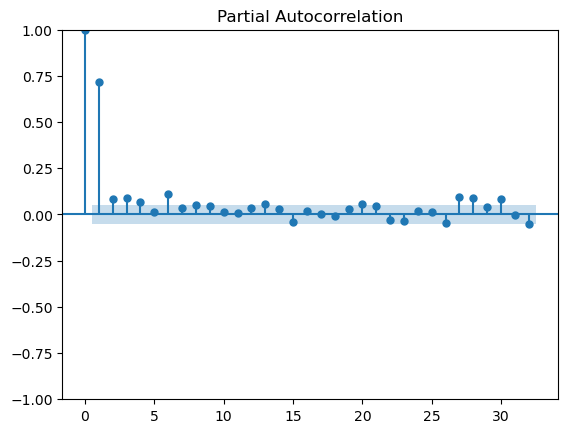

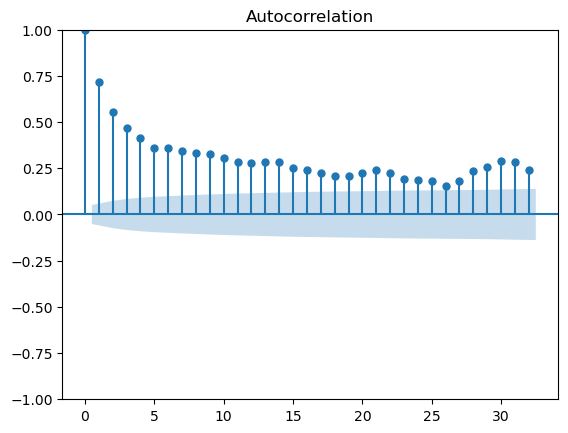

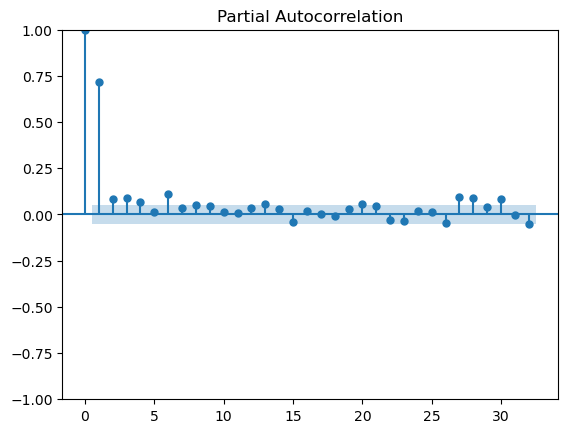

In [37]:
# Autocorrelation in residuals
model = lm.fit(x, y)
residuals = lm.predict(x)-y
sm.graphics.tsa.plot_acf(residuals)
sm.graphics.tsa.plot_pacf(residuals)

# autocorrelation is existed, which shows the time series model such as sarima is needed in the next step

The first Partial Autocorrelation Function (PACF) plot, showing a strong correlation at lag 1 and minimal correlation afterward. This suggests an autoregressive component at lag 1. 
The second graph is an Autocorrelation Function (ACF) plot, which displays a slow decay across multiple lags, indicating persistent autocorrelation and a possible need for differencing. These plots suggest the data has time-dependent structures and may benefit from an ARIMA model for effective modeling.

Regarding the report by Blanca Barón and Snow Lee, ARIMA would be the best model for forecasting the electricity consumption as it effectively handles data with seasonal patterns. ARIMA models are well-suited for time series forecasting, allowing for understanding and predicting future values based on past data patterns.

Building on the methodologies from the two reports on electricity consumption forecasting, enhancing an ARIMA model could involve refining data pre-processing techniques, such as outlier detection and correction based on the characteristics of submeters data. Leveraging a more comprehensive grid search for ARIMA parameters, as suggested in the second part, can fine-tune the model’s accuracy. Additionally, incorporating a rolling forecast mechanism could improve adaptability to new data, thereby enhancing predictive performance in real-world scenarios. This approach aligns with the detailed statistical analysis and forecasting methods discussed in the reports.

The Prophet model is useful for this project because it is designed to handle time series data with strong seasonal patterns and holidays, which are likely influential factors in household electricity consumption. Prophet can automatically capture daily, weekly, and yearly seasonal effects, making it ideal for forecasting energy demand across different seasons and holidays.

### Machine Learning Morphism

### 1. Exploratory Data Analysis (EDA)

As the data preprocessing has already been finished, a more comprehensive Exploratory Data Analysis (EDA) will be conducted to understand the underlying trends and seasonal patterns in the data.Trend and Seasonality Visualization: Use line plots to visualize the trend over time. Seasonal decomposition helps reveal seasonal cycles, and monthly or weekly box plots help identify seasonal variations in electricity consumption.
ACF and PACF Plots: Generated Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF) plots to inform the SARIMA parameters:
p: Determine the autoregressive order by examining significant lags in the PACF plot.
d: If differencing is required for stationarity, the number of differencing steps is set here.
q: Moving average order is informed by the ACF plot.

### 2. Model Selection and Configuration

**SARIMA Model Configuration**

**Parameter Tuning:**

SARIMA (p, d, q) x (P, D, Q, s): Tune these parameters using insights from the ACF and PACF plots and grid search on (P, D, Q, s) seasonal parameters.

Seasonal Period (s): Set based on data’s seasonality (e.g., s=12 for monthly seasonality if using monthly aggregated data).

**Implement the Model:**

Use the statsmodels library to implement SARIMA with the optimal parameters. SARIMA works well with regular, seasonal patterns and performs better with stationary data after differencing.

**Prophet Model Configuration**

Automated Seasonal and Holiday Adjustments: Prophet allows the incorporation of daily, weekly, and yearly seasonalities automatically, which makes it ideal for datasets with clear periodic trends.

Holiday Effects: Manually add holidays if they impact electricity usage, such as major holidays when electricity consumption may increase. Prophet models each seasonal and holiday effect as an additive component.

Capacity for Missing Data and Outliers: Prophet automatically handles missing values and adjusts for outliers, making it resilient in real-world, noisy datasets like electricity consumption.

### 3. Model Training and Hyperparameter Tuning

**SARIMA Tuning:**

Use Grid Search to fine-tune SARIMA parameters based on criteria like Akaike Information Criterion (AIC) or Bayesian Information Criterion (BIC). These metrics help balance model complexity and fit quality.

Cross-validation: Implement time series cross-validation with a rolling origin or expanding window approach to ensure that each model configuration is tested on future data points.

**Prophet Tuning:**

Prophet requires fewer parameter adjustments but can be fine-tuned for:

Seasonal Period Adjustments: Custom seasonal periods can be added if there are known unique cycles in the data.

Hyperparameters: Adjusting changepoint_prior_scale (controls flexibility of trend changes) and seasonality_prior_scale (controls flexibility of seasonal components) can improve fit on specific data characteristics.

### 4. Model Evaluation

Measure Root Mean Squared Error (RMSE), Mean Absolute Error (MAE), and Mean Absolute Percentage Error (MAPE): Measure forecast accuracy. Lower values indicate better performance.

Both models generate confidence intervals for predictions. These intervals indicate the uncertainty range around the forecast, which is essential for planning in real-world applications like energy management.

### 5. Model Forecasting

**SARIMA Forecasting:** Use the SARIMA model to forecast future electricity consumption over the desired time horizon. Plot the forecast alongside historical data to visually assess the accuracy and reliability of the predictions. Also, Observe the ACF and PACF of the residuals to verify that the SARIMA model effectively captured the data’s time-based patterns.

**Prophet Forecasting:** Use Prophet’s built-in prediction functionality to generate forecasts with trend and seasonal adjustments. Visualize the individual components (trend, seasonality, holidays) to understand the impact of each on the forecast. In addition, Prophet’s decomposition of trends and seasonality allows easy interpretation of each component, providing insights into consumption patterns over time.

### 6. Continuous Improvement

**Retraining Schedule:** Periodically retrain SARIMA to capture new patterns in electricity consumption. For Prophet, add recent data points without full retraining due to its adaptive nature.

**Integration of External Factors:** Enhance the models by incorporating external factors (e.g., weather data like temperature and humidity) that influence electricity consumption. These factors can be added as covariates in Prophet or additional seasonal effects.

**Performance Monitoring:** Track model performance using real-time metrics to identify when retraining is necessary. Implement a monitoring framework that alerts when performance metrics exceed set thresholds.

### Model Introduction

#### ARIMA

The **ARIMA** model is a traditional and robust statistical method for univariate time series forecasting. It combines autoregression (AR), moving averages (MA), and differencing (I) to model the linear relationships in the data. ARIMA models are best suited for stationary time series and can effectively capture the temporal dependencies between observations when data is properly differenced and preprocessed (Neptune AI).

**Strengths of ARIMA:**

Autoregressive capabilities: ARIMA’s reliance on past values (AR terms) helps in capturing significant historical dependencies.

Differencing and Stationarity: ARIMA requires the data to be stationary, and differencing helps remove trends, making the data more suitable for accurate forecasting.

Flexibility: ARIMA can be tailored with appropriate tuning of parameters (p, d, q), making it highly versatile across different time series datasets.

**Limitations of ARIMA:**

Assumes linearity: ARIMA models linear relationships, which may limit its performance when dealing with complex, non-linear patterns.

Limited handling of seasonality: Seasonal trends need specialized models like SARIMA to account for seasonality.

#### Prophet

The **Prophet model**, developed by Facebook, is designed specifically for time series with clear seasonal patterns and holidays, which makes it highly suitable for business forecasting scenarios. Unlike ARIMA, Prophet is based on an additive model where the forecast is decomposed into trend, seasonality, and holidays components (Facebook Research).

**Strengths of Prophet:**

Ease of use: Prophet is user-friendly and requires minimal parameter tuning, making it accessible for non-experts.

Seasonality and trend handling: It excels in capturing complex, multi-seasonal patterns, making it ideal for datasets that exhibit seasonal variations, such as electricity consumption, which can vary with temperature or time of year.

Handling of missing data: Prophet can handle missing data points without requiring any special preprocessing, giving it an advantage in noisy real-world datasets.

**Limitations of Prophet:**

Less precise for short-term forecasting: Prophet may not be as accurate as ARIMA when forecasting very short time horizons, particularly in non-seasonal data (McAuley).

Manual holiday input: Prophet requires manual input of holiday data, which can be cumbersome in certain applications.

## 4. Source Code

https://github.com/urfive5/Electricity-Consumption-Forecasting

## 5. Next Step

**Week 9 and 10:** Develop SARIMA Model

**Week 11:** Develop Prophet Model

**Week 12:** Compare and Improve the Two Models

## 6. References

1. Blanca Baron. (2018). *ARIMA model for time series forecasting*. Retrieved from https://rpubs.com/blancabaron/395376

2. Snow Lee. (2019). *Step-by-step: ARIMA model for forecasting*. Retrieved from https://www.rpubs.com/snowlee26/552314

3. UCI Machine Learning Repository. (2012). Individual Household Electric Power Consumption Data Set. Retrieved from https://archive.ics.uci.edu/dataset/235/individual+household+electric+power+consumption

4. McAuley, J., Pham, A., & Balasubramaniam, R. MLM Framework for Hospital Readmission Prediction. (2022). Retrieved from https://rpubs.com/blancabaron/395376.

5. Neptune AI. ARIMA vs Prophet vs LSTM for Time Series Prediction. (2023). Retrieved from https://neptune.ai/blog/ARIMA-vs-Prophet-vs-LSTM.

6. Facebook Research. Prophet: Forecasting at Scale. (2017). Retrieved from https://facebookresearch.github.io/prophet/.